Name = Nishant Rahul Dandwate

Task 2(Customer Segmentation and Market Basket Analysis)

In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx',  parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.shape

(541909, 8)

In [5]:
df.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


# Data Cleansing

In [6]:
#Ensure that the data type in the InvoiceNo column is in the form of a string.
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

In [7]:
df.sort_values('InvoiceNo', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom
...,...,...,...,...,...,...,...,...
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom


InvoiceNo that starts with the letter 'C' indicates a canceled transaction. We will delete this data, because we will analyze only successful transactions.

In [8]:
#Delete canceled transaction rows
df = df[~df['InvoiceNo'].str.contains('C')]

In [9]:
df.shape

(532621, 8)

In [10]:
def missingvalue(data):
    missing_value = data.isnull().sum(axis = 0).reset_index()
    missing_value.columns = ['variable', 'number_of_missing']
    missing_value['percentage_of_missing'] = (missing_value['number_of_missing'])/data.shape[0]*100
    mv = missing_value.sort_values('percentage_of_missing', ascending = False).reset_index(drop=True)
    return mv
missingvalue(df)

,variable,number_of_missing,percentage_of_missing
0,CustomerID,134697,25.289465
1,Description,1454,0.272990
2,InvoiceNo,0,0.000000
3,StockCode,0,0.000000
4,Quantity,0,0.000000
5,InvoiceDate,0,0.000000
6,UnitPrice,0,0.000000
7,Country,0,0.000000


We have missing values in the CustomerID and Description columns. Because the data is large, dropping the missing values will not cause a problem in data size. Additionally, CustomerlD and Description can not be filled because it will affect the analysis later.

In [11]:
df = df.dropna(subset = ['CustomerID', 'Description'])

In [12]:
missingvalue(df)

,variable,number_of_missing,percentage_of_missing
0,InvoiceNo,0,0.0
1,StockCode,0,0.0
2,Description,0,0.0
3,Quantity,0,0.0
4,InvoiceDate,0,0.0
5,UnitPrice,0,0.0
6,CustomerID,0,0.0
7,Country,0,0.0


In [13]:
#Remove spaces at the beginning or end of sentences
df['Description'] = df['Description'].str.strip()

In [14]:
df.shape

(397924, 8)

In [15]:
df.info()
df['CustomerID'] = df['CustomerID'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [16]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


# Exploratory Data Analysis

### What products do customers buy the most?

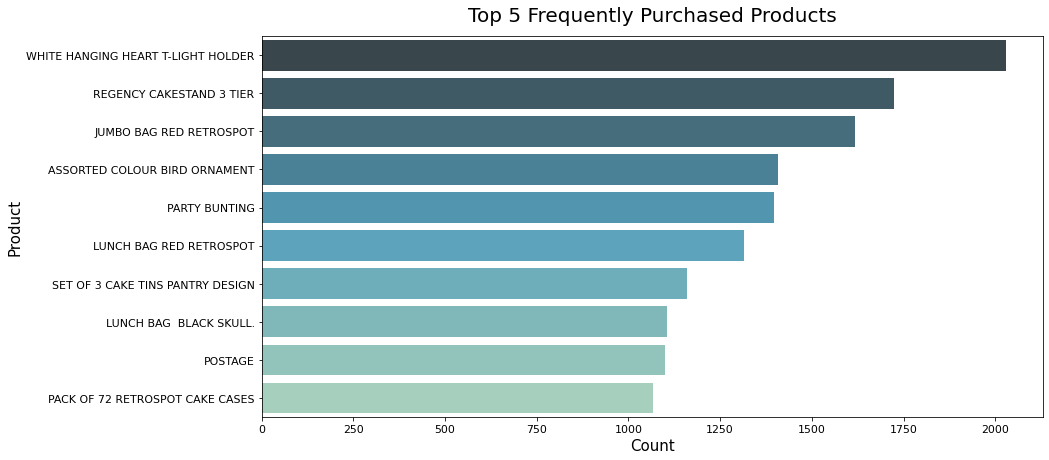

In [17]:
plt.figure(figsize = (14,7))
ax = sns.countplot(y = df['Description'], 
                   order = df["Description"].value_counts().iloc[:10].index, 
                   palette = "GnBu_d")
ax.set_title("Top 5 Frequently Purchased Products", size = 20, pad=15)
ax.set_xlabel("Count", size = 15)
ax.set_ylabel("Product", size = 15)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
plt.show()

The white hanging heart t-light holder is the product most often purchased by customers.

### How many orders (per month)?

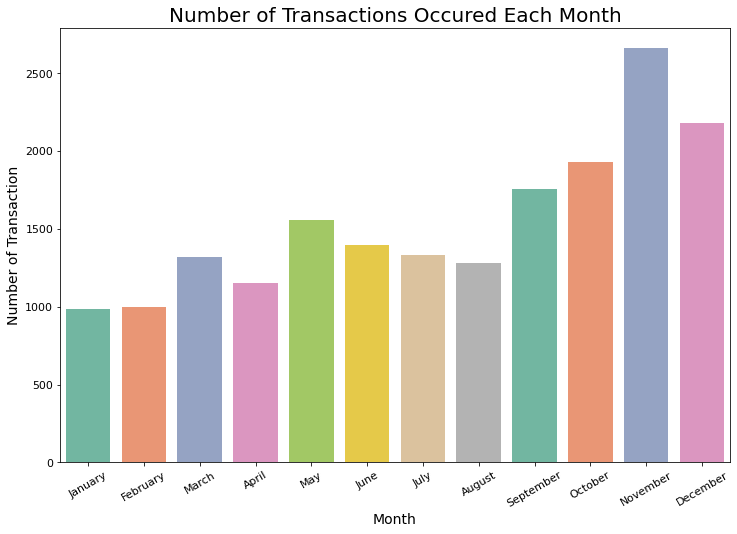

In [18]:
order_month = df.groupby(df['InvoiceDate'].dt.month)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_month.reset_index(), palette = "Set2")
ax.set_title('Number of Transactions Occured Each Month', size = 20)
ax.set_xlabel('Month', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], rotation = 30)
plt.show()

Most transactions were in November as it was near the holidays. Also, it is likely that many people are buying gifts for Christmas in November.

### How many orders (per day)?

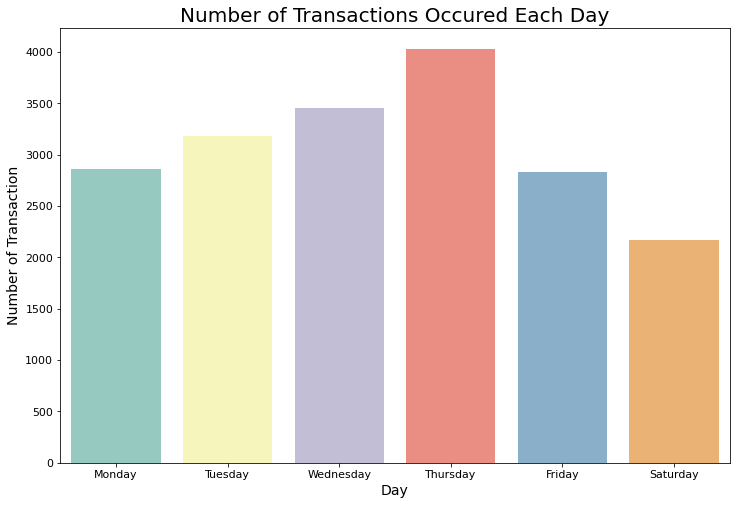

In [19]:
order_day = df.groupby(df['InvoiceDate'].dt.dayofweek)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_day.reset_index(), palette = "Set3")
ax.set_title('Number of Transactions Occured Each Day', size = 20)
ax.set_xlabel('Day', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.show()

Thursday is the busiest day and Saturday is the least busy day.

### How many orders (per hour)?

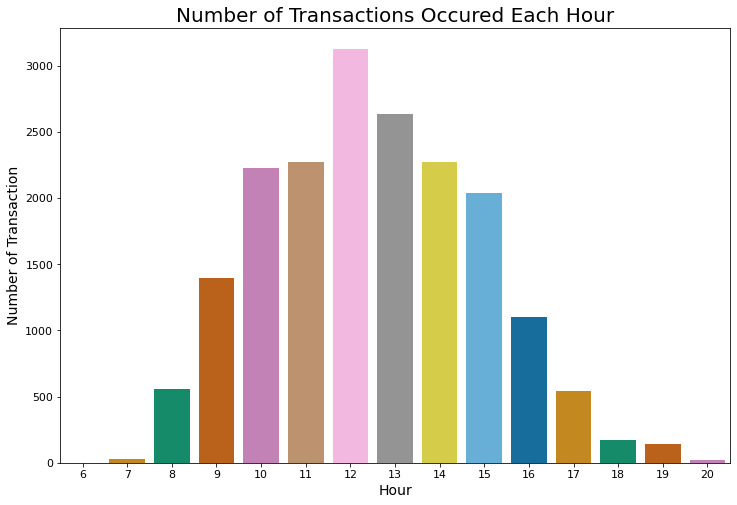

In [20]:
order_hour = df.groupby(df['InvoiceDate'].dt.hour)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_hour.reset_index(), palette = "colorblind")
ax.set_title('Number of Transactions Occured Each Hour', size = 20)
ax.set_xlabel('Hour', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
plt.show()

Most orders are between 12 AM and 1PM. There is a possibility because at that time people take a break from work and can order goods at online retail.

### Who are the 5 customers who spend the most money on Online Retail? 

In [21]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [22]:
price_cust = pd.pivot_table(df, index='CustomerID', values='TotalPrice', aggfunc=np.sum)
print('The following are 5 customers who spend the most money on Online Retail:')
price_cust.sort_values('TotalPrice', ascending=False)[:5]

The following are 5 customers who spend the most money on Online Retail:


,TotalPrice
CustomerID,
14646,280206.02
18102,259657.30
17450,194550.79
16446,168472.50
14911,143825.06


Customer with ID 14646 is the customer who spent the most money in online retail, which is $280,206.02

### Who are the five most frequent customer shopping in Online Retail?

In [23]:
order_cust = pd.pivot_table(df, index='CustomerID', values='InvoiceNo', aggfunc=pd.Series.nunique)
print('The following are the 5 customers who most frequently shop at Online Retail:')
order_cust.sort_values('InvoiceNo', ascending=False)[:5]

The following are the 5 customers who most frequently shop at Online Retail:


,InvoiceNo
CustomerID,
12748,210
14911,201
17841,124
13089,97
14606,93


Customer with ID 12748 is the most frequent customer shopping in online retail, with 210 transactions. <br>
Customers with ID 14911 are customers who frequently shop and spend a lot of money at online retail.

### Time Cohorts

First of all, we will retrieve the InvoiceMonth data.

In [24]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

In [25]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


Next, we will create a CohortMonth, which is the time when customers first shop.

In [26]:
group = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = group.transform('min')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01


In [27]:
def date(data, column):
    year = data[column].dt.year
    month = data[column].dt.month
    day = data[column].dt.day
    return year, month, day

In [28]:
invoice_year, invoice_month, _ = date(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = date(df, 'CohortMonth')

Furthermore, the month difference will be calculated between the first customer shopping at the retail store and the invoice time.<br>
Difference in years and months

In [29]:
diff_year = invoice_year - cohort_year
diff_month = invoice_month - cohort_month

The IndexTime column describes the month difference between the first purchase and the purchase on InvoiceMonth. An addition is made by 1 so that the first month is counted as 1, not 0.

In [30]:
df['IndexTime'] = diff_year*12 + diff_month + 1
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,IndexTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,5


In [31]:
count_cohort_time = df.groupby(['CohortMonth', 'IndexTime'])['CustomerID'].apply(pd.Series.nunique)
count_cohort_time = count_cohort_time.reset_index()
cohort_time_table = count_cohort_time.pivot(index='CohortMonth', columns='IndexTime', values='CustomerID')
cohort_time_table

IndexTime,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Customer Retention Rate**
Customer retention is a very useful metric to understand how many of all the customers are still active. Customer retention rate designates the percentage of customers the company has retained over a given time period. Retention rate is a reverse side of churn rate, which shows the percentage of customers a company has lost over a specific period.


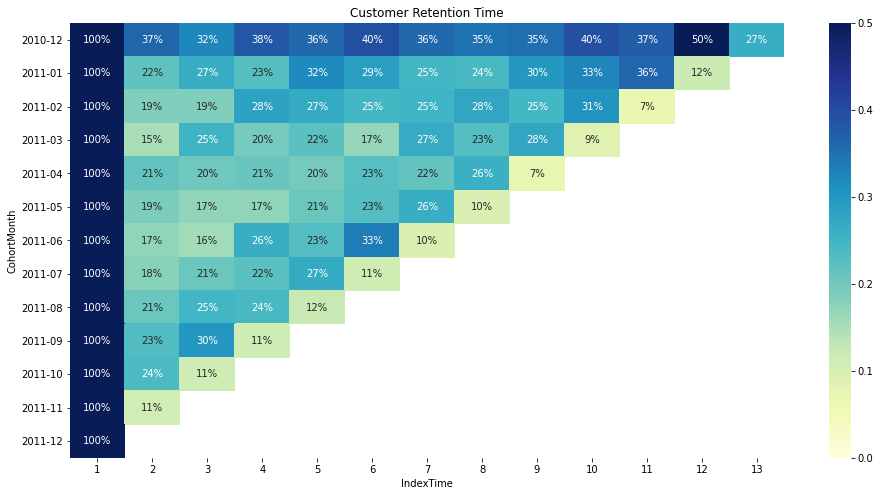

In [32]:
cohort_size = cohort_time_table.iloc[:,0]
#Divide all values in the cohort_time_table by cohort_size
retention = cohort_time_table.divide(cohort_size, axis = 0)
retention.index = retention.index.strftime('%Y-%m')
plt.figure(figsize= (16,8))
ax = sns.heatmap(data = retention, annot = True, annot_kws={"size":10}, vmin = 0.0, vmax = 0.5, fmt = '.0%', cmap = 'YlGnBu')
plt.title('Customer Retention Time')
plt.show()

On average, the number of customers that online retail has successfully retained is less than 50%. Online retail should evaluate the marketing methods it does. Or online retail can provide special points for each customer who transact and can be exchanged for prizes.

In [33]:
print('Min: {}\nMax: {}'.format(min(df['InvoiceDate']), max(df['InvoiceDate'])))

Min: 2010-12-01 08:26:00
Max: 2011-12-09 12:50:00


In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,IndexTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1


We assume that we are analyzing on analysis_date. The analysis date is 1 day from the last date on InvoiceDate.

In [35]:
analysis_date = max(df['InvoiceDate']) + dt.timedelta(days= 1)
print((analysis_date).date())

2011-12-10


In [36]:
rfm_cust = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'})
rfm_cust.rename(columns= {'InvoiceDate':'Recency',
                         'InvoiceNo':'Frequency',
                         'TotalPrice':'Monetary'}, inplace = True)
rfm_cust

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40
...,...,...,...
18280,278,10,180.60
18281,181,7,80.82
18282,8,12,178.05


### RFM quartile
We will divide the RFM into 4 parts.

In [37]:
#1 is the best and 4 is the worst
r_labels = range(1,5) #The longer the customer last purchase, the worse it is
f_labels = range(4,0,-1) #The more purchases the customer makes, the better it is
m_labels = range(4,0,-1) #The more money the customer spends, the better it is

r_quartiles = pd.qcut(rfm_cust['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm_cust['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm_cust['Monetary'], q=4, labels=m_labels)

rfm_cust = rfm_cust.assign(R = r_quartiles.values, F = f_quartiles.values, M = m_quartiles.values)

rfm_cust

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,326,1,77183.60,4,4,1
12347,2,182,4310.00,1,1,1
12348,75,31,1797.24,3,3,1
12349,19,73,1757.55,2,2,1
12350,310,17,334.40,4,4,3
...,...,...,...,...,...,...
18280,278,10,180.60,4,4,4
18281,181,7,80.82,4,4,4
18282,8,12,178.05,1,4,4


In [38]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])
rfm_cust['RFM_Segment'] = rfm_cust.apply(join_rfm, axis=1)
rfm_cust['RFM_Score'] = rfm_cust[['R', 'F', 'M']].sum(axis=1)
rfm_cust.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,4,4,1,441,9.0
12347,2,182,4310.00,1,1,1,111,3.0
12348,75,31,1797.24,3,3,1,331,7.0
12349,19,73,1757.55,2,2,1,221,5.0
12350,310,17,334.40,4,4,3,443,11.0


In [39]:
rfm_cust.groupby('RFM_Segment').size().sort_values(ascending=False)

RFM_Segment
111    447
444    384
211    217
433    206
344    179
      ... 
241      7
141      6
431      5
413      4
114      3
Length: 61, dtype: int64

As we can see, the lowest and the highest rated RFM segments are among the largest ones

Summary metrics for each RFM Score

In [40]:
rfm_cust.groupby('RFM_Score').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0           7.3     374.5   9319.2   447
4.0          21.1     187.7   4083.2   392
5.0          32.1     112.3   2049.4   426
6.0          46.0      80.0   1801.4   417
7.0          64.6      56.8    994.1   454
8.0          79.1      38.5    755.5   459
9.0          96.3      27.9    824.0   461
10.0        154.3      21.4    368.5   516
11.0        175.7      13.6    239.6   383
12.0        260.8       8.2    158.9   384

In [41]:
loyalty_level =['Platinum','Gold','Silver','Bronze']
loyalty_quartile = pd.qcut(rfm_cust['RFM_Score'], q=4, labels=loyalty_level)
rfm_cust['Loyalty_Level'] = loyalty_quartile.values
rfm_cust

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Loyalty_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,4,4,1,441,9.0,Silver
12347,2,182,4310.00,1,1,1,111,3.0,Platinum
12348,75,31,1797.24,3,3,1,331,7.0,Gold
12349,19,73,1757.55,2,2,1,221,5.0,Platinum
12350,310,17,334.40,4,4,3,443,11.0,Bronze
...,...,...,...,...,...,...,...,...,...
18280,278,10,180.60,4,4,4,444,12.0,Bronze
18281,181,7,80.82,4,4,4,444,12.0,Bronze
18282,8,12,178.05,1,4,4,144,9.0,Silver


In [42]:
rfm_cust.groupby('Loyalty_Level').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
                 mean      mean     mean count
Loyalty_Level                                 
Platinum         19.9     228.3   5248.5  1265
Gold             63.8      57.8   1164.9  1330
Silver          127.0      24.5    583.4   977
Bronze          218.3      10.9    199.2   767

## Key k-means assumptions
1. Symmetric distribution of variables (not skewed)
2. Variables with same average values
3. Variables with same variance

In [43]:
def rfm_dist(column):
    r_skew = rfm_cust[column].skew()

    plt.rcParams['font.size']=13
    plt.figure(figsize=(10,6))
    sns.distplot(rfm_cust[column], color = 'tomato', kde_kws={"color": "k"})
    plt.title('{} Distribution'.format(column))

    plt.show()
    print('Skewness value of data {}: {}'.format(column, r_skew))

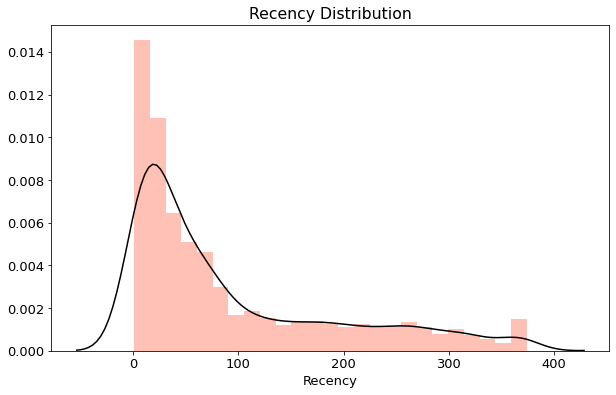

Skewness value of data Recency: 1.2463568823921842


In [44]:
rfm_dist('Recency')

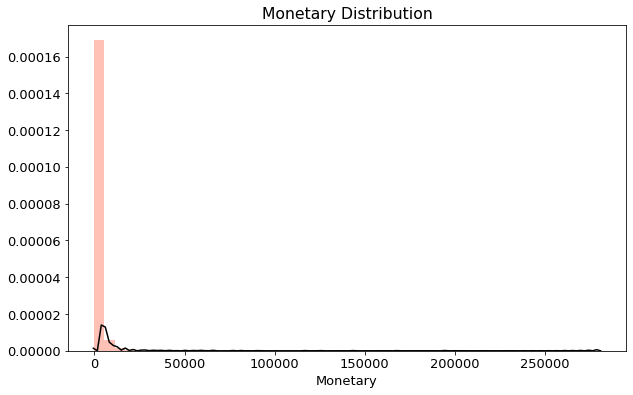

Skewness value of data Monetary: 19.326985305561827


In [45]:
rfm_dist('Monetary')

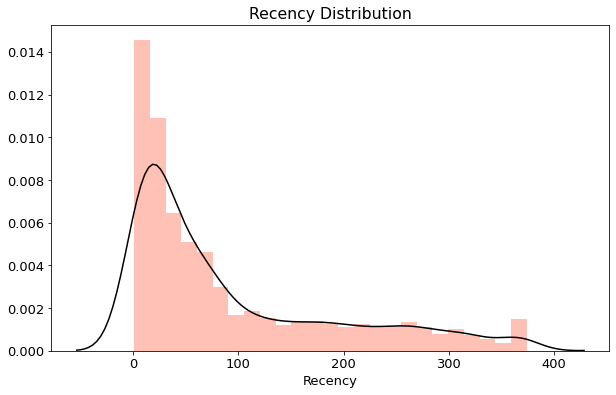

Skewness value of data Recency: 1.2463568823921842


In [46]:
rfm_dist('Recency')

In [47]:
print("The following is the skewness value for Recency, Frequency, and Monetary data:",
      '\nRecency   : {}'.format(rfm_cust['Recency'].skew()),
      '\nFrequency : {}'.format(rfm_cust['Frequency'].skew()),
      '\nMonetary  : {}'.format(rfm_cust['Monetary'].skew()))

The following is the skewness value for Recency, Frequency, and Monetary data: 
Recency   : 1.2463568823921842 
Frequency : 18.106242903118684 
Monetary  : 19.326985305561827


As a general rule of thumb:<br>
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. <br>
If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed. <br>
If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed. <br>

From the general rule of thumb, it can be concluded that data Recency, Frequency, and Monetary are highly positive skew. So, the data must be transformed (Data Transformation) to make it into a normal distribution.

In [48]:
rfm_norm = rfm_cust[['Recency','Frequency','Monetary']]
rfm_norm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,91.708689,2053.793018
std,100.009747,228.792852,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.000000,100.000000,1661.640000
max,374.000000,7847.000000,280206.020000


In [49]:
power = PowerTransformer().fit(rfm_norm)
rfm_transform =power.transform(rfm_norm)

#Standard Scaler to Scale the data
scaler = StandardScaler().fit(rfm_transform)
rfm_transform = scaler.transform(rfm_transform)

rfm_transform =pd.DataFrame(rfm_transform, index=rfm_norm.index, columns=rfm_norm.columns)
print('These are the mean value after data transformation:')
rfm_transform.describe()

These are the mean value after data transformation:


,Recency,Frequency,Monetary
count,4.339000e+03,4.339000e+03,4.339000e+03
mean,-6.951368e-17,-3.149768e-17,-7.786146e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.023615e+00,-2.420116e+00,-6.771115e+00
25%,-7.262454e-01,-6.778752e-01,-6.640781e-01
50%,-7.919785e-04,-1.754355e-03,-1.423703e-02
75%,8.380272e-01,7.009493e-01,6.862765e-01
max,1.755177e+00,4.225204e+00,3.885827e+00


In [50]:
def rfm_dist_transform(column):
    r_skew_transform = rfm_transform[column].skew()

    plt.rcParams['font.size']=13
    plt.figure(figsize=(10,6))
    sns.distplot(rfm_transform[column], color = 'g', kde_kws={"color": "k"})
    plt.title('{} Distribution after Data Transformation'.format(column))

    plt.show()
    print('Skewness value of data {} after data transformation: {}'.format(column, r_skew_transform))

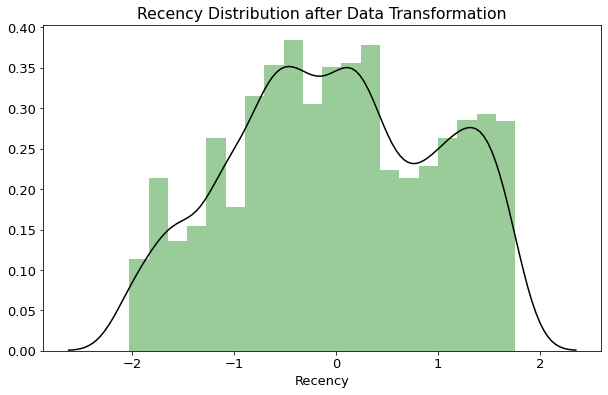

Skewness value of data Recency after data transformation: -0.05649210191594949


In [51]:
rfm_dist_transform('Recency')

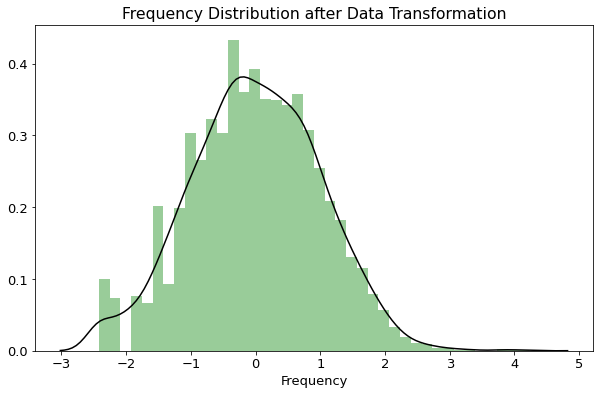

Skewness value of data Frequency after data transformation: -0.00010277002306379692


In [52]:
rfm_dist_transform('Frequency')

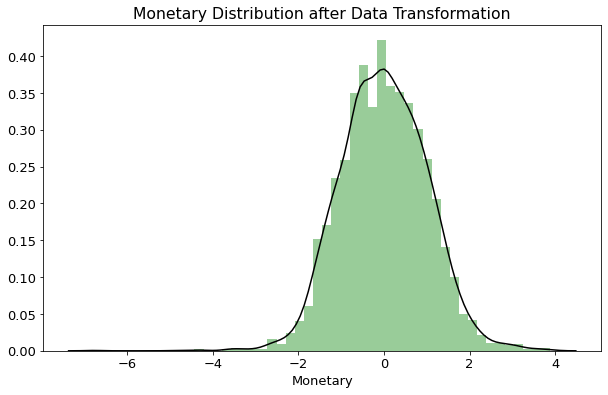

Skewness value of data Monetary after data transformation: -0.02275333701575156


In [53]:
rfm_dist_transform('Monetary')

In [54]:
print("The following is the skewness value for Recency, Frequency, and Monetary data after data transformation:",
      '\nRecency   : {}'.format(rfm_transform['Recency'].skew()),
      '\nFrequency : {}'.format(rfm_transform['Frequency'].skew()),
      '\nMonetary  : {}'.format(rfm_transform['Monetary'].skew()))

The following is the skewness value for Recency, Frequency, and Monetary data after data transformation: 
Recency   : -0.05649210191594949 
Frequency : -0.00010277002306379692 
Monetary  : -0.02275333701575156


Since the skewness values are between -0.5 to 0.5, or close to 0, it can be assumed that the RFM data has a normal distribution.

## Determining the number of clusters

### Elbow Method
The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and for each value of k, calculate the sum of squared errors (SSE). The idea of elbow method is to choose K at SSE decreases abruptly.


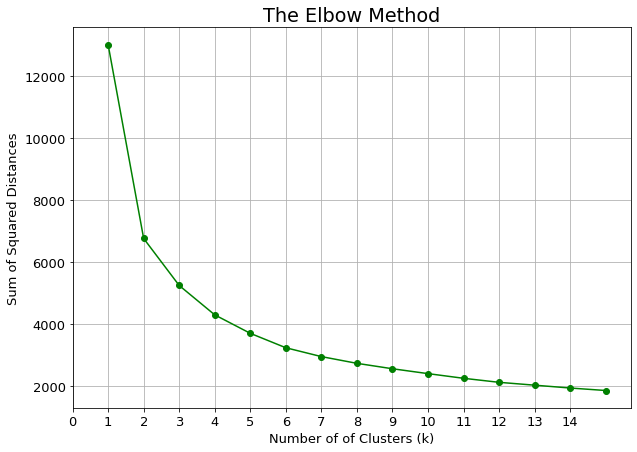

In [55]:
#Elbow Method
inertia=[]
cl = 15

for i in range(1,cl+1):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans.fit(rfm_transform)
    inertia.append(kmeans.inertia_) #sum of squared distances to closest cluster center


fig,ax = plt.subplots()
fig.set_size_inches(10, 7)
plt.rcParams['font.size']=16
plt.plot(range(1,cl+1), inertia, 'o-', color = 'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.title('The Elbow Method')
plt.xlabel('Number of of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)
plt.show()

###Silhouette Analysis
Silhouette displays a measure of how close each point in one cluster is to points in the neighbouring clusters. Silhouette score has a range of [-1, 1] 
*   A value near +1 indicate that the sample is far away from the neighbouring clusters.
*   A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters.
*   Negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.396689892885645
For n_clusters = 3 The average silhouette_score is : 0.29914201439769766
For n_clusters = 4 The average silhouette_score is : 0.3049761899444196
For n_clusters = 5 The average silhouette_score is : 0.27896014859955187
For n_clusters = 6 The average silhouette_score is : 0.27702545910278


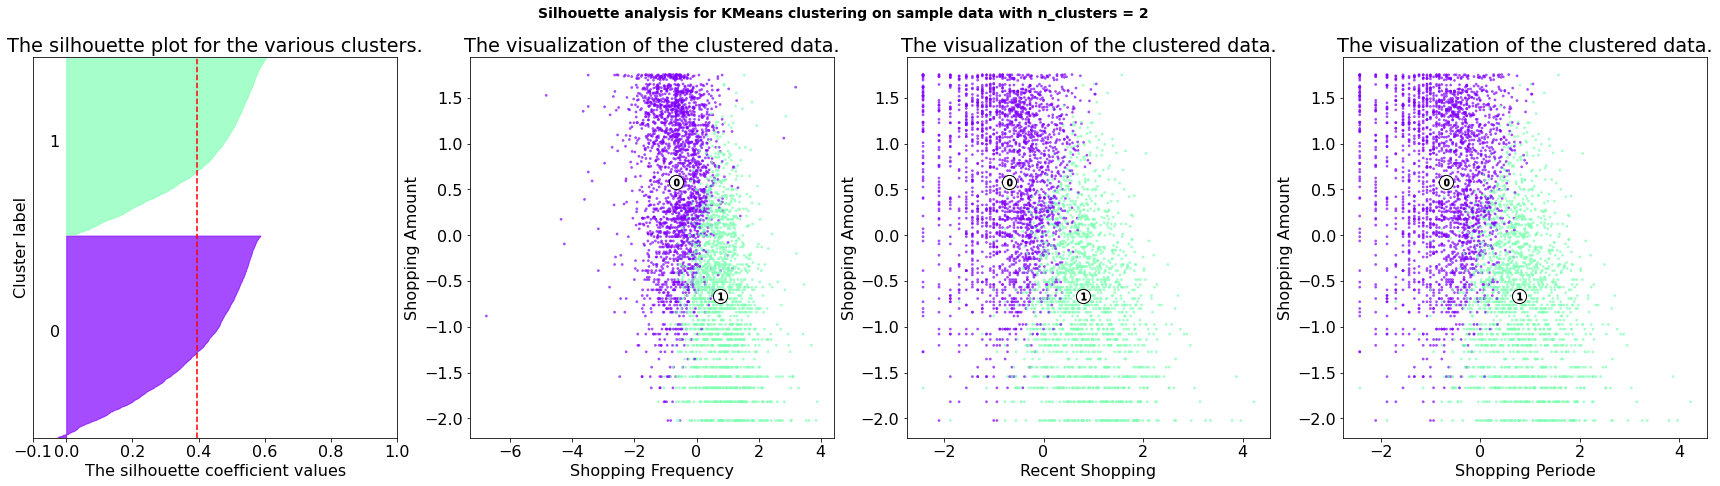

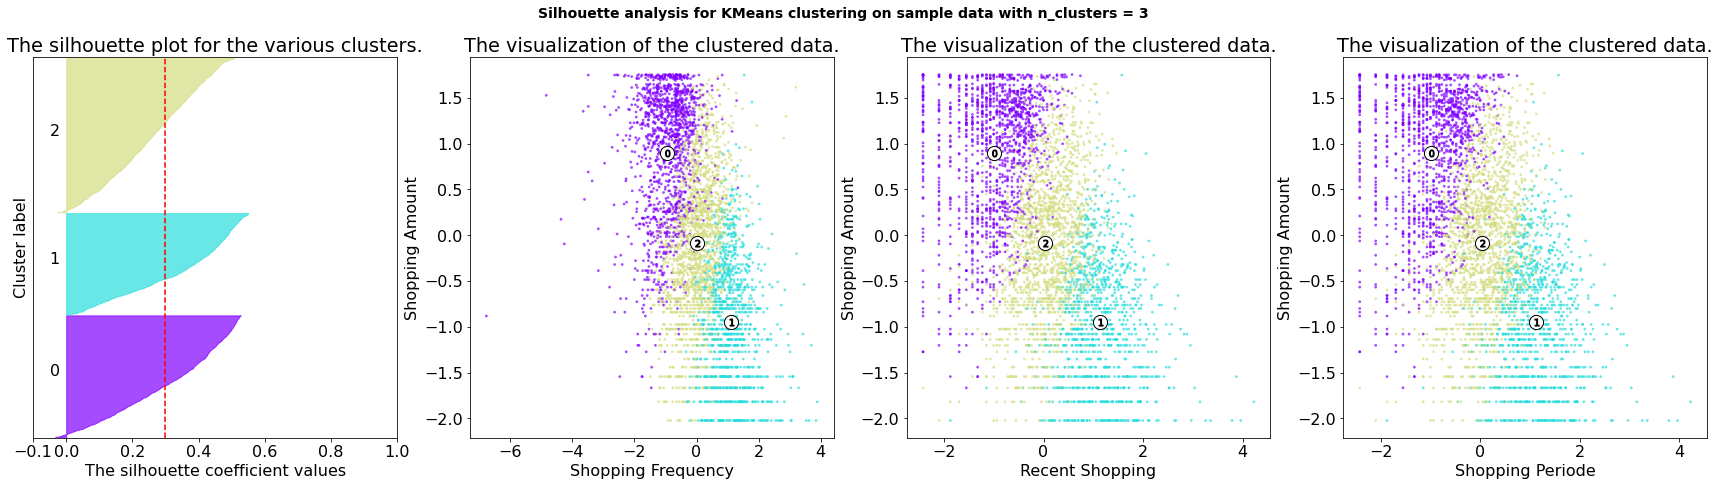

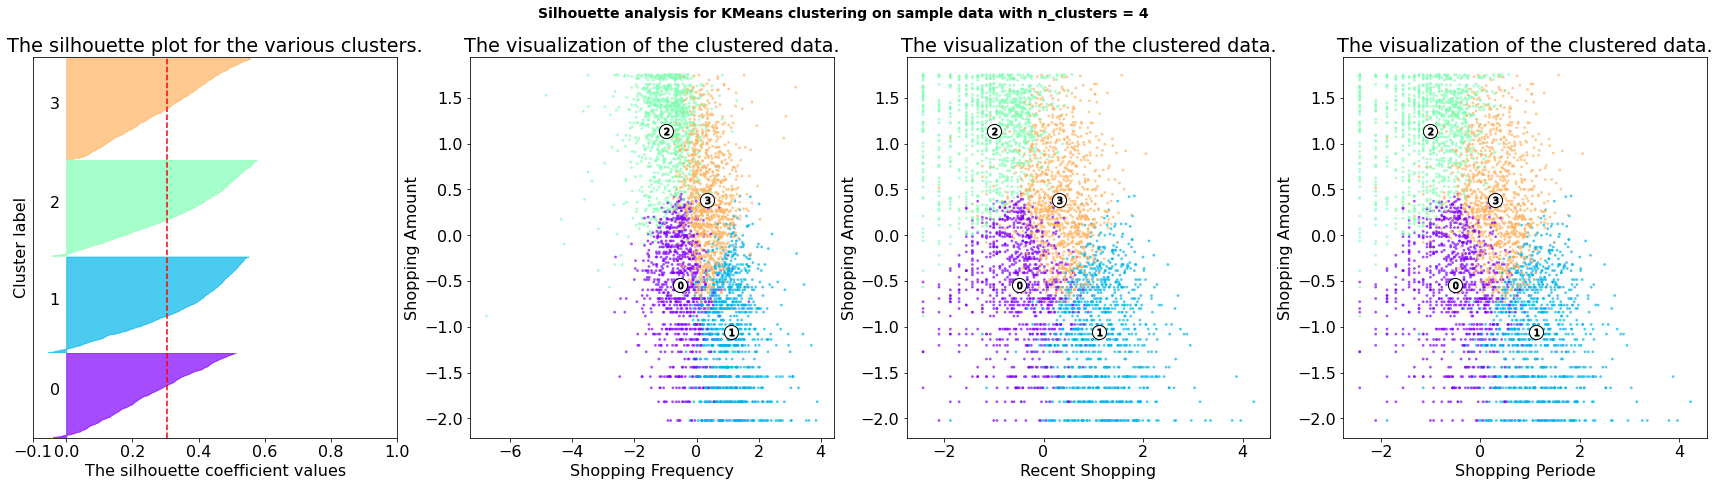

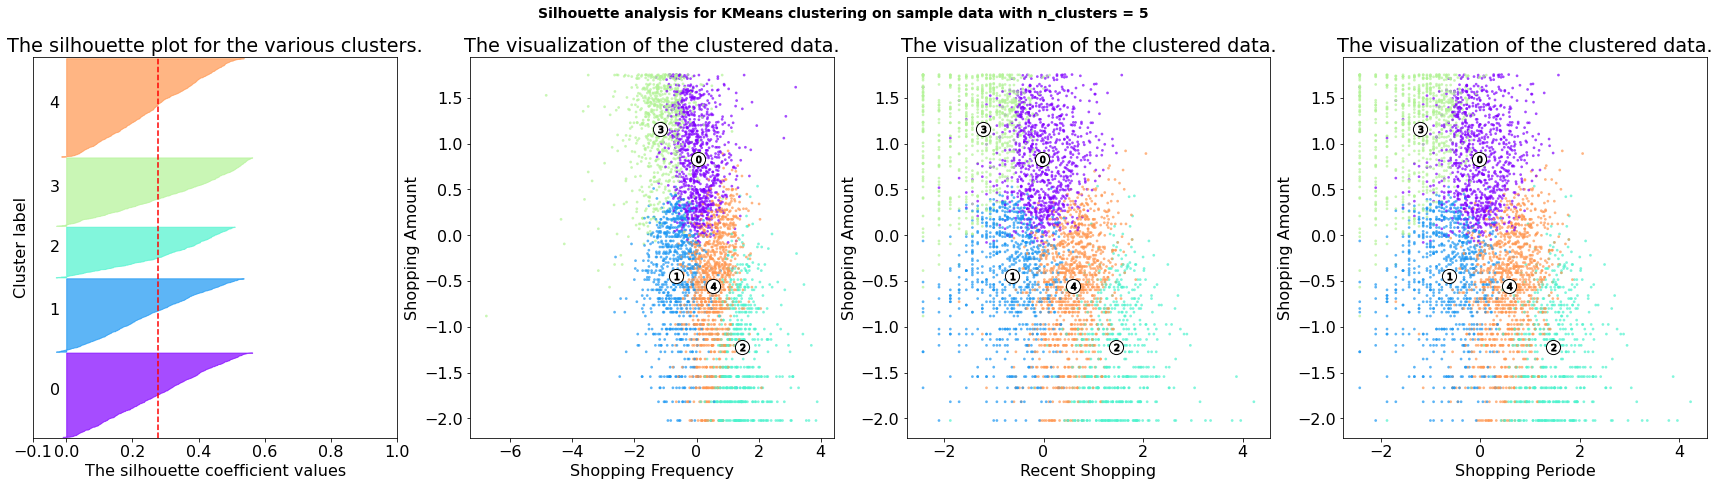

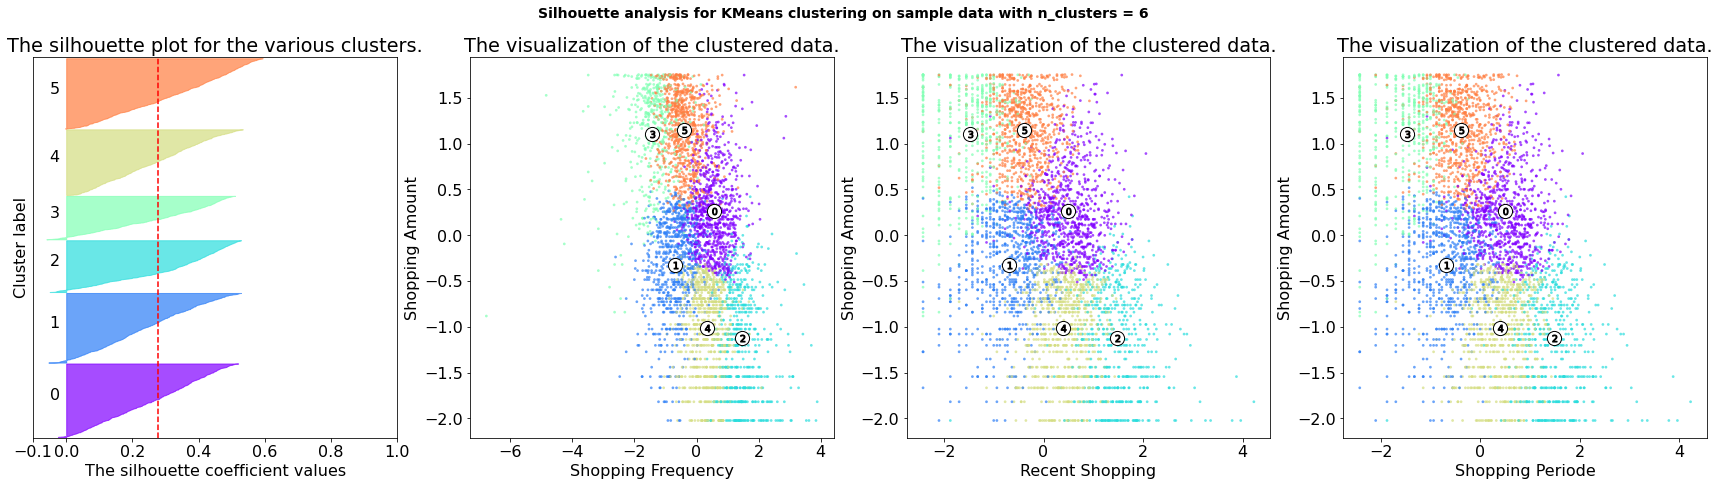

In [56]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(30, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_transform) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_transform)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_transform, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_transform, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_transform['Monetary'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 2], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[2], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Shopping Frequency")
    ax2.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
        # 3nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax3.scatter(rfm_transform['Frequency'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("The visualization of the clustered data.")
    ax3.set_xlabel("Recent Shopping")
    ax3.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    

    # 4nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax4.scatter(rfm_transform['Frequency'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("The visualization of the clustered data.")
    ax4.set_xlabel("Shopping Periode")
    ax4.set_ylabel("Shopping Amount")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


plt.show()

We will choose 4 clusters based on the elbow method, because there is no significant decrease in sum of squared distance or SSE after 4 clusters. Based on the silhouette analysis, the silhouette_score that is close to 1 is for the number of clusters 2 and 4.By combining the elbow method and silhouette analysis, the number of clusters 4 is selected.

## KMeans Clustering

In [57]:
n = 4

model = KMeans(n_clusters=n,init='k-means++',max_iter=300, n_init=10, random_state=0)

#fit the data
model_kmeans = model.fit(rfm_transform)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model_kmeans.labels_

centers = model_kmeans.cluster_centers_

#Append labels/clusters to scaled and original dataframe
rfm_cust['Cluster'] = labels
clusters_seg = pd.DataFrame(rfm_transform,columns=['Recency','Frequency','Monetary'])
clusters_seg['Cluster'] = labels+1

clusters = []

for i in range(0,n):
    clusters.append(rfm_cust[rfm_cust['Cluster']==i])

values = power.inverse_transform(scaler.inverse_transform(centers))

for i in range(0,n):
    print('-----CLUSTER {}-----'.format(i+1))
    print('Number of Customers: {}'.format(clusters[i].shape[0]))
    print('(Recency)Last Day Shopping: {:4.0f}'.format(values[i][0]))
    print('(Frec)Purchases Frequency : {:4.0f}'.format(values[i][1]))
    print('(Monetary)Total purchases: £{:6.2f}\n'.format(values[i][2]))

-----CLUSTER 1-----
Number of Customers: 957
(Recency)Last Day Shopping:   24
(Frec)Purchases Frequency :   21
(Monetary)Total purchases: £351.52

-----CLUSTER 2-----
Number of Customers: 1122
(Recency)Last Day Shopping:  197
(Frec)Purchases Frequency :   11
(Monetary)Total purchases: £218.21

-----CLUSTER 3-----
Number of Customers: 1071
(Recency)Last Day Shopping:   10
(Frec)Purchases Frequency :  171
(Monetary)Total purchases: £2957.32

-----CLUSTER 4-----
Number of Customers: 1189
(Recency)Last Day Shopping:   79
(Frec)Purchases Frequency :   62
(Monetary)Total purchases: £1065.84



In [58]:
rfm_transform['Cluster'] = model_kmeans.labels_
rfm_transform.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,1.617262,-2.420116,3.193082,3
12347,-1.818927,1.178407,1.377477,2
12348,0.300127,-0.219010,0.745038,3
12349,-0.691692,0.451547,0.728345,2
12350,1.567401,-0.677875,-0.592290,1


In [59]:
rfm_cust.groupby('Cluster').agg({'Recency':'mean',
                                 'Frequency':'mean',
                                 'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          29.9      27.3    452.6   957
1         216.2      15.1    293.5  1122
2          14.2     248.4   6003.4  1071
3          96.8      74.7   1446.1  1189

## Snake plot
*   Market research technique to compare different segments
*   Visual representation of each segment's attributes

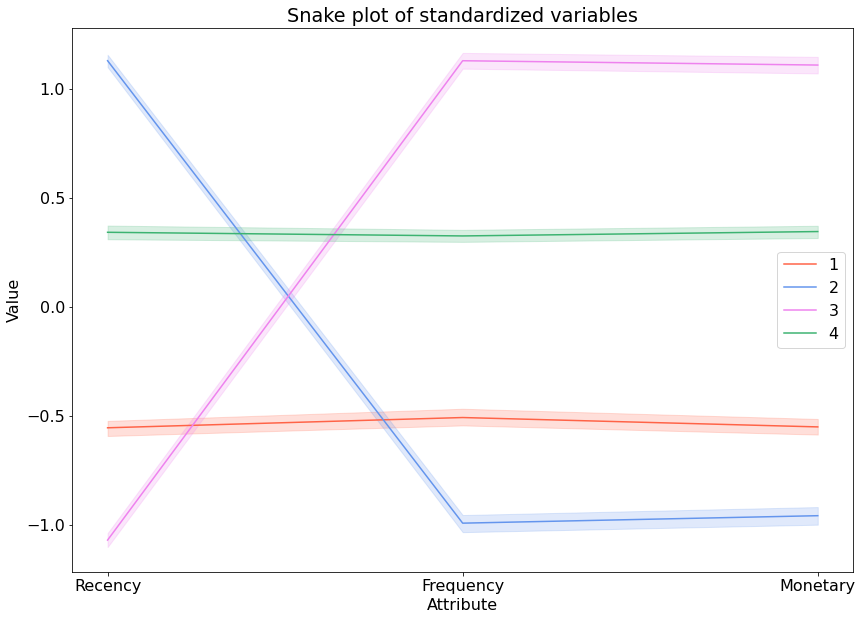

In [60]:
data_melt = pd.melt(rfm_transform.reset_index(), id_vars=['CustomerID','Cluster'], value_vars=['Recency','Frequency','Monetary'], var_name='Attribute', value_name='Value')
plt.figure(figsize=(14,10))
plt.title('Snake plot of standardized variables')
ax = sns.lineplot(x='Attribute', y='Value', hue='Cluster',palette=['tomato','cornflowerblue','violet','mediumseagreen'], data=data_melt, sort=False)
ax.legend(['1','2','3','4'])
plt.show()

The lower the Recency value, the better it is. The higher the Frequency and Monetary values, the better it is.

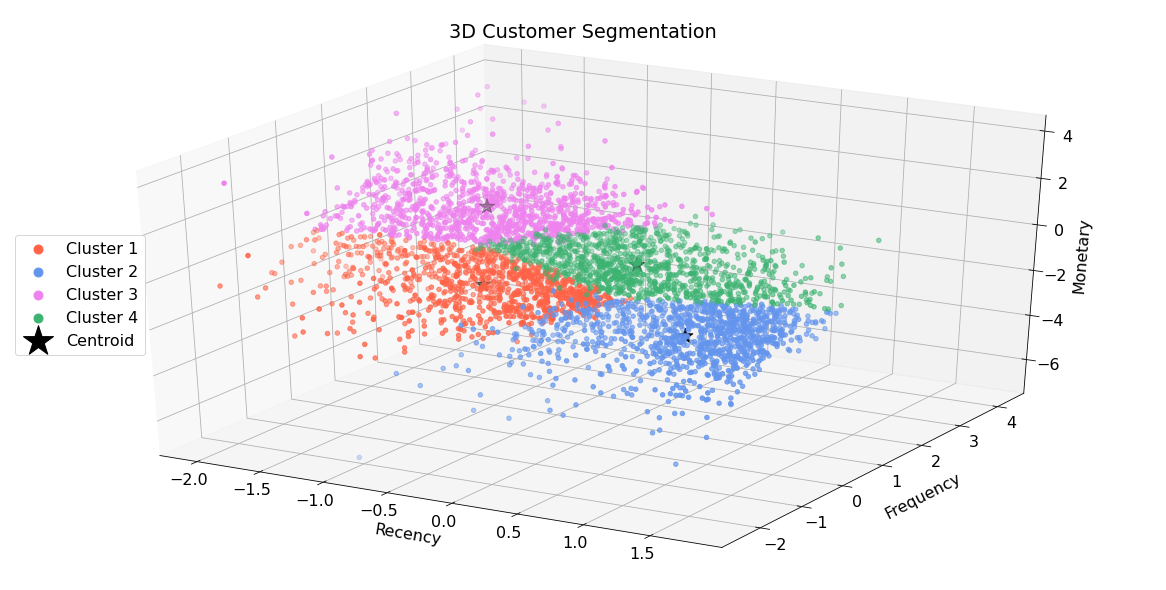

In [61]:
fig = plt.figure(figsize=(16,8))
ax=Axes3D(fig)
ax.scatter(rfm_transform[rfm_transform['Cluster']==0]['Recency'],rfm_transform[rfm_transform['Cluster']==0]['Frequency'],rfm_transform[rfm_transform['Cluster']==0]['Monetary'],color='tomato', label='Cluster 1')
ax.scatter(rfm_transform[rfm_transform['Cluster']==1]['Recency'],rfm_transform[rfm_transform['Cluster']==1]['Frequency'],rfm_transform[rfm_transform['Cluster']==1]['Monetary'],color='cornflowerblue', label='Cluster 2')
ax.scatter(rfm_transform[rfm_transform['Cluster']==2]['Recency'],rfm_transform[rfm_transform['Cluster']==2]['Frequency'],rfm_transform[rfm_transform['Cluster']==2]['Monetary'],color='violet', label='Cluster 3')
ax.scatter(rfm_transform[rfm_transform['Cluster']==3]['Recency'],rfm_transform[rfm_transform['Cluster']==3]['Frequency'],rfm_transform[rfm_transform['Cluster']==3]['Monetary'],color='mediumseagreen', label='Cluster 4')
ax.scatter(centers[:,0], centers[:,1], centers[:,2], s = 250, c = 'k', marker='*', label = 'Centroid')
plt.legend(loc='center left',markerscale=2)
plt.title('3D Customer Segmentation', pad = 15)
ax.set_xlabel('Recency', labelpad = 15)
ax.set_ylabel('Frequency', labelpad = 15)
ax.set_zlabel('Monetary')
plt.show()

# **Conclusion Customer Segmentation**
1. Cluster 3 is our **Champion Customers**<br>
Champion customers are the best customers, new buyers, most frequently, and are heavy buyers. Reward this customer. They can be early adopters for new products and will help promote your brand.
2. Cluster 4 is our **At Risk Customers**<br>
At Risk Customers are customers who often buy and spend a lot of money, but haven't been shopping recently. We can provide offers or discounts to these customers, so that they are interested in shopping again at our store.
3. Cluster 1 is our **Promising Customers** <br>
Promising customers are customers who have been shopping recently, but the frequency and amount of money spent in our stores is still small or below average. Create brand awareness and provide discounts.
4. Cluster 2 is our **Lost Customers** <br>
Lost customers are customers who have not been shopping for a long time, and the frequency and amount of money spent is also very low. Revive their interest with reach out campaign, ignore otherwise.


>**Support** <br>It measures the percentage of itemset occurrence in all transactions.<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1c6acacd3b17051205704b5d323c83fc737e5db1" style="left:50%">


>**Confidence** <br>Confidence measures how strong the association rule is. How often item Y appears in the purchase transaction of item X.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/90324dedc399441696116eed3658fd17c5da4329" style="left:50%">

>**Lift** <br>Lift of the rule is defined as the ratio of observed support to the support expected in the case the elements of the rule were independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c392e3111167b60687405dfdc7ed55f22409f4c5" style="left:50%">


In [62]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [63]:
print('Top 5 Country in Online Retail:')
df['Country'].value_counts()[:5]

Top 5 Country in Online Retail:


United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

In [64]:
df = df[df['Country']=='United Kingdom']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,IndexTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [65]:
basket = df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,...,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [66]:
def encode_units(x):
  if x <= 0:
    return 0
  if x >= 1:
    return 1
basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', axis = 1, inplace = True)
basket_sets.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,...,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
frequent_itemsets = apriori(basket_sets, min_support = 0.02, use_colnames= True)

In [68]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.086912,0.048772,0.030392,0.349689,7.169917,0.026153,1.462728
13,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.048772,0.086912,0.030392,0.623153,7.169917,0.026153,2.422965
27,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.067271,0.059823,0.029071,0.432143,7.223641,0.025046,1.655657
26,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.059823,0.067271,0.029071,0.485944,7.223641,0.025046,1.814449
6,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.036759,0.040723,0.028590,0.777778,19.099148,0.027093,4.316746
...,...,...,...,...,...,...,...,...,...
45,(LUNCH BAG PINK POLKADOT),(LUNCH BAG SPACEBOY DESIGN),0.050934,0.052436,0.020061,0.393868,7.511463,0.017391,1.563297
32,(LUNCH BAG RED RETROSPOT),(LUNCH BAG APPLE DESIGN),0.067271,0.044807,0.020001,0.297321,6.635529,0.016987,1.359359
33,(LUNCH BAG APPLE DESIGN),(LUNCH BAG RED RETROSPOT),0.044807,0.067271,0.020001,0.446381,6.635529,0.016987,1.684784
46,(LUNCH BAG SUKI DESIGN),(LUNCH BAG PINK POLKADOT),0.050213,0.050934,0.020001,0.398325,7.820423,0.017444,1.577374


In [69]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029611,0.036759,0.024266,0.819473,22.293137,0.023177,5.335706
71,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024266,0.040723,0.020482,0.844059,20.726763,0.019494,6.151553
72,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023004,0.036759,0.020482,0.890339,24.221015,0.019636,8.783841


# Conclusion Market Basket Analysis
From the market basket analysis, it is found that customers who buy PINK REGENCY TEACUP AND SAUCER tend to buy GREEN REGENCY TEACUP AND SAUCER. The three most frequent associations for lift over 6 and confidence above 8 are items related to teacup and saucer. Perhaps we can provide more color variants on the teacup.